In [1]:
import itertools
import sys
from pathlib import Path

import h5py as h5
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm

sys.path.append('../lib')
from local_paths import preproc_dir, analysis_dir, database_dir, cache_dir
from storage import get_storage_functions, quantize
from im_patches import get_patches_from_grid
from cross_val_pred import standardize, cv_split_by_image, cv_ridge_predict, pearsonr

# Parameters

In [2]:
#============================================================================
# session
#============================================================================
sess_name = 'sess_name'


#============================================================================
# coefs for weighting stimulus features
#============================================================================
# the values to calculate are analogous to the coefficient of multiple correlations,
# with the key differences that the linear model here is
# 1. cross-validated
# 2. regularized via ridge regression (as implemented)
# 3. regularized via weight sharing, for all RF locations other than
#    that (if any) used to fit the model

# how to fit coefs
# - *peak* of model performance map (prerequisite)
#   this will also inherit CV splits to keep them uncontaminated
# - *full_image* regardless of fixation position
# - *fovea* regardless of fixation position
fit_coefs_at = 'peak'

# required only if fit_coefs_at == 'peak'
rfmap_analysis = 'model_perf_map'
rfmap_dset = 'corr_per_split'  # must have the same splits as here


#============================================================================
# spatiotemporal resolution of RF
#============================================================================
# temporal
t_aln  = 'sacc_on'  # 'sacc_on' or 'fix_on'
# response windows
# - one (long) window, if > 0
t_win  =   0
# - OTHERWISE, sliding window
t_pre  = 375
t_post = 375  # inclusive, but window must fit fully in range
t_step =  25

# spatial
xy_min  = -7  # dva
xy_max  =  7
xy_step =  1  # only meaningful if at least patch step size in cached reprs;
              # note that patch size is set in cached reprs


#============================================================================
# fixation/saccade selection
#============================================================================
# fixation criteria
ifix_sel        =    1    # 0: zeroth-fix only; 1: non-zeroth-fix only; otherwise: both
select_saccades = True    # must be False if ifix_sel is None or 0


#============================================================================
# modelling
#============================================================================
# ridge regularization
ridge_alpha = 100000

# cross-validation
n_splits    =      5
group_kfold =   True


#============================================================================
# paths
#============================================================================
proc_dir = preproc_dir

sdf_dir = preproc_dir
sdf_suffix = '-mwa_1' if t_win > 0 else '-mwa_50'  # default to no smoothing if using a response window

feat_dir = cache_dir + 'feats/vit_large_patch16_384/blocks.13.attn.qkv'
feat_suffix = '_as_2x2_in_0.50_steps'

unit_sel_path = None
latency_path = database_dir + 'per_unit_latency-fix_on.csv.gz'  # only used # if t_win > 0

rfmap_dir = analysis_dir + rfmap_analysis  # required only if fit_coefs_at is set to 'peak'

output_dir = analysis_dir + 'feat_corr_map'

In [3]:
# Parameters
sess_name = "Pa210201"
t_aln = "fix_on"
t_win = 200
ifix_sel = 2
select_saccades = False
sdf_suffix = "-mwa_1"
output_dir = "../test_results/maps_fix"
rfmap_dir = "../test_results/maps_fix"


# Check prereqs and params

In [4]:
proc_path = Path(proc_dir) / (sess_name + '-proc.h5')
print('Loading shared processing from', proc_path)
proc_path = proc_path.expanduser()
assert proc_path.is_file()

sdf_path = Path(sdf_dir) / (sess_name + f'-sdf{sdf_suffix}.h5')
print('Loading spike density function from', sdf_path)
sdf_path = sdf_path.expanduser()
assert sdf_path.is_file()

with h5.File(proc_path, 'r') as f:
    im_w, im_h = im_size = f['stimulus/size_dva'][()]
feats_path = Path(feat_dir) / f'{im_w:.1f}x{im_h:.1f}{feat_suffix}.h5'
print('Loading cached model features from', feats_path)
feats_path = feats_path.expanduser()
assert feats_path.is_file()

if t_win > 0:
    print('Using per-unit latency from', latency_path)
    latency_path = Path(latency_path).expanduser()
    assert latency_path.is_file()

if unit_sel_path is not None:
    print('Loading unit selection from', unit_sel_path)
    unit_sel_path = Path(unit_sel_path).expanduser()
    assert unit_sel_path.is_file()
    unit_names = pd.read_csv(unit_sel_path).set_index('Session').loc[[sess_name]]['Unit'].values
else:
    unit_names = None

if fit_coefs_at == 'peak':
    rfmap_path = Path(rfmap_dir) / (sess_name + '.h5')
    print('Loading maps (to determine loc for coef fit) from', rfmap_path)
    rfmap_path = rfmap_path.expanduser()
    assert rfmap_path.is_file()

output_dir = Path(output_dir)
assert output_dir.expanduser().is_dir()
output_path = output_dir / (sess_name + '.h5')
print('Saving results to', output_path)
output_path = output_path.expanduser()

Loading shared processing from ../test_data/Pa210201-proc.h5
Loading spike density function from ../test_data/Pa210201-sdf-mwa_1.h5
Loading cached model features from ~/Data/FreeViewing/Cache/feats/vit_large_patch16_384/blocks.13.attn.qkv/16.0x16.0_as_2x2_in_0.50_steps.h5
Using per-unit latency from ../db/per_unit_latency-fix_on.csv.gz
Loading maps (to determine loc for coef fit) from ../test_results/maps_fix/Pa210201.h5
Saving results to ../test_results/maps_fix/Pa210201.h5


In [5]:
assert fit_coefs_at in ('peak', 'full_image', 'fovea')

In [6]:
analysis_name = 'feat_corr_map'

if output_path.is_file():
    with h5.File(output_path, 'r') as f:
        try:
            if f[f'progress_report/{analysis_name}/all_done'][()].item():
                raise RuntimeError(f'{sess_name} has already been processed')
        except KeyError:
            pass

In [7]:
fix_df = pd.read_hdf(proc_path, 'fixation_dataframe', 'r')
with h5.File(proc_path, 'r') as f:
    stim_folder_ = f['stimulus/folder'][()].decode()

imids = fix_df.groupby(['Image subdir', 'Image filename']).first().index
md5s = [Path(fn).stem for _, fn in imids]
md5_catalog = pd.DataFrame(index=imids, data=md5s, columns=['MD5'])

# Prepare parameters; save config

In [8]:
with h5.File(proc_path, 'r') as f:
    random_seed = f['config/default_random_seed'][()]
print('random_seed:', random_seed)

random_seed: 775418045


In [9]:
with h5.File(proc_path, 'r') as f:
    if select_saccades:
        assert ifix_sel == 1, 'if selecting saccades, must only include non-zeroth fixations'
        fix1_sel, fix2_sel = f['saccade_selection/fixation_indices'][()]
    else:
        assert t_aln == 'fix_on'
        fix2_sel = f['fixation_selection/fixation_indices'][()]
        if ifix_sel in (0, 1):
            m = 0 == fix_df.index.get_level_values(fix_df.index.names.index('Fixation'))[fix2_sel]
            if ifix_sel == 1:
                m = ~m
            fix2_sel = fix2_sel[m]

In [10]:
assert t_aln in ('sacc_on', 'fix_on')
if t_win > 0:
    ts = np.array([t_win/2])  # placeholder; actual window varies with latency per unit
else:
    ts = np.arange(-t_pre, t_post+.1, t_step)
print(f'Response windows ({len(ts)}): {ts}')

rf_locs = np.arange(xy_min, xy_max+xy_step/10, xy_step)
print(f'RF locations ({len(rf_locs)}): {rf_locs}')
tb = (rf_locs[0]-xy_step/2, rf_locs[-1]+xy_step/2)
rf_extent = tb + tb

Response windows (1): [100.]
RF locations (15): [-7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.]


In [11]:
save_results, add_attr_to_dset, check_equals_saved, link_dsets, copy_group = \
    get_storage_functions(output_path)

In [12]:
group = analysis_name + '/'
save_results(group+'ts', ts, attrs=dict(unit='ms'))
save_results(group+'rf_locs', rf_locs, attrs=dict(unit='dva'))
save_results(group+'sdf_suffix', sdf_suffix)

group = analysis_name + '/config/'
save_results(group+'random_seed', random_seed)
save_results(group+'fit_coefs_at', fit_coefs_at)
save_results(group+'rfmap_analysis', rfmap_analysis)
save_results(group+'rfmap_dset', rfmap_dset)

group = analysis_name + '/config/time_windows/'
save_results(group+'t_aln', t_aln)
save_results(group+'t_win', t_win)
save_results(group+'t_pre', t_pre)
save_results(group+'t_post', t_post)
save_results(group+'t_step', t_step)
add_attr_to_dset(group, attrs=dict(unit='ms'))

group = analysis_name + '/config/retinotopic_locations/'
save_results(group+'xy_min', xy_min)
save_results(group+'xy_max', xy_max)
save_results(group+'xy_step', xy_step)
add_attr_to_dset(group, attrs=dict(unit='dva'))

group = analysis_name + '/config/fixation_selection/'
save_results(group+'ifix_sel', ifix_sel)
save_results(group+'select_saccades', select_saccades)

group = analysis_name + '/config/modelling/'
save_results(group+'n_splits', n_splits)
save_results(group+'ridge_alpha', ridge_alpha)
save_results(group+'group_kfold', group_kfold)

# For saccades, construct two types of control points
- Control 1: the 3rd vertex of two equilateral triangles anchored by fix 1 & 2 (previous and current), i.e., the L4/5 Langange points. One of the points is chosen:
  - If both points are within image bounds, choose randomly
  - If one and only one point is within image bounds, choose that
  - If both points are outside image bounds, choose the one closest to the image.
- Control 2: the midpoint between the previous and current fixation, i.e., the L1 point.

In [13]:
xys_fix2 = fix_df.iloc[fix2_sel][['Relative X', 'Relative Y']].values.astype(float)
if select_saccades:
    xys_fix1 = fix_df.iloc[fix1_sel][['Relative X', 'Relative Y']].values.astype(float)

In [14]:
if not select_saccades:
    n_cond = 1

else:
    n_cond = 4
    rg = np.random.default_rng(random_seed)

    # control point type 2: midpoint between fixs 1, 2
    xys_control2 = (xys_fix1 + xys_fix2) / 2

    # control point type 1
    # - get 3rd vertex of the equilateral triangle
    #   by rotating the saccade vector +/-60 degs
    vs = xys_fix2 - xys_fix1
    rmats = [
        np.array([[np.cos(a), -np.sin(a)], [np.sin(a), np.cos(a)]])
        for a in (np.pi/3, -np.pi/3)
    ]
    xys_l45 = xys_fix1 + np.array([(m @ vs.T).T for m in rmats])  # shape (n_fix, 2)

    # - check whether/how far points are out of image bounds
    d2b = np.array([
        [
            np.max([xys[:,j]-im_size[j]/2, -im_size[j]/2-xys[:,j]], axis=0)
            for j in range(2)
        ]
        for xys in xys_l45
    ])  # shape (2, 2, n_fix)
    oob = np.any(d2b >= 0, axis=1)  # shape (2, n_fix)

    # - choose one of the two candidate control points according to 1 of 3 conditions
    m0 = np.all(oob, axis=0)
    m2 = np.all(~oob, axis=0)
    m1 = ~(m0 | m2)
    xys_control1 = np.empty_like(xys_fix1)
    if np.any(m0):
        xys_control1[m0] = [xys_l45[np.argmin(d2b[...,i].max(1)), i] for i in np.nonzero(m0)[0]]
    if np.any(m1):
        xys_control1[m1] = [xys_l45[np.argmin(oob[:,i]), i] for i in np.nonzero(m1)[0]]
    if np.any(m2):
        rand_par = (rg.random(size=m2.sum()) < 0.5).astype(int)
        xys_control1[m2] = [xys_l45[p, i] for p, i in zip(rand_par, np.nonzero(m2)[0])]

    # - quality control
    for i, xys in enumerate((xys_fix1, xys_fix2, xys_control1, xys_control2)):
        if i < 2:
            # sanity check: control point must be equidistant to both fixations
            assert np.allclose(np.linalg.norm(xys_control1 - xys, axis=1), np.linalg.norm(vs, axis=1))

        d2b_ = np.array([
            np.max([xys[:,j]-im_size[j]/2, -im_size[j]/2-xys[:,j]], axis=0)
            for j in range(2)
        ])
        m = np.any(d2b_ >= 0, 0)
        d2b__ = d2b_[:,m].max(0)
        cond = ('Fixation 1', 'Fixation 2', 'Control 1 (equidist)', 'Control 2 (midpoint)')[i]
        print(f'{cond +":":<18}\t{m.mean()*100:4.1f}% out of image boundary', end='')
        if np.any(m):
            print(f'; d = {d2b__.mean():.1f} +/- {d2b__.std():.1f}')
        else:
            print()
        d2b__ = -(d2b_.max(0))
        print(f'\tmean min dist to bound: {d2b__.mean():.1f} +/- {d2b__.std():.1f} dva')

In [15]:
ref_frames = np.array(('fix1', 'fix2', 'equidistant', 'midpoint')[:n_cond])
if select_saccades:
    xy_degs_conds = (xys_fix1, xys_fix2, xys_control1, xys_control2)
else:
    xy_degs_conds = (xys_fix2,)
    ref_frames = ref_frames[:1]

In [16]:
group = analysis_name + '/fix_sel'
if select_saccades:
    save_results(
        group, np.array([fix1_sel, fix2_sel]),
        attrs=dict(dims=np.array(['fix_1_or_2', 'index'], dtype=np.bytes_)))
else:
    save_results(
        group, fix2_sel,
        attrs=dict(dims=np.array(['index'], dtype=np.bytes_)))

if select_saccades:
    group = analysis_name + '/control_points/'
    attrs = dict(dims=np.array(['index', 'xy'], dtype=np.bytes_), unit='dva', comment='Relative to image center')
    save_results(group+'equidistant', xys_control1, attrs=attrs)
    save_results(group+'midpoint', xys_control2, attrs=attrs)

# Get aligned responses

In [17]:
with h5.File(sdf_path, 'r') as f:
    dset = f['sdf']
    all_unit_names = dset.attrs['unit_names'].astype(str)
    if unit_names is None:
        unit_names = all_unit_names
        unit_sel = slice(None)
        if 'unit_names' in f:
            copy_group(f, 'unit_names', analysis_name+'/unit_names')
    else:
        all_unit_names = list(all_unit_names)
        unit_sel = np.array([v in unit_names for v in all_unit_names])

    sdf = dset[()][:,unit_sel]

n_neur = sdf.shape[1]

In [18]:
if t_win > 0:
    lat_df = pd.read_csv(latency_path).set_index('Session').loc[[sess_name]].set_index('Name')
    m = pd.Series(unit_names).isin(lat_df.index)
    assert m.all(), f'missing latency values for {(~m).sum()} of {m.size} units'
    assert not lat_df.index.has_duplicates
    lat_df = lat_df.loc[unit_names].reset_index()
    assert len(lat_df) == len(unit_names)
    lat_df['Index'] = np.arange(len(lat_df))
    lat_df['Latency'] = np.clip(lat_df['Latency'], 40, None)
    print('Num units using RF fit from each source:')
    print('\t' + '\n\t'.join(str(lat_df.groupby('Source').count()['Latency']).split('\n')[:-1]))
    lat_df.to_hdf(output_path, analysis_name+'/latency_per_unit', mode='a', format='table', complevel=9, complib='zlib')

Num units using RF fit from each source:
	Source
	Array                 29
	Array, across sess    40
	Channel               11
	Unit                  12


In [19]:
if t_aln == 'sacc_on':
    t0s = fix_df.iloc[fix1_sel][['Time', 'Duration']].values.sum(1)
else:
    t0s = fix_df.iloc[fix2_sel]['Time'].values

resps = np.empty_like(sdf, shape=(fix2_sel.size, ts.size, n_neur))

if t_win > 0:
    t_win_ = np.array([0, t_win])
    lat_groups = [(dt, df_['Index'].values) for dt, df_ in lat_df.groupby('Latency')]
    for i, t in enumerate(t0s):
        for dt, usel in lat_groups:
            s = slice(*np.round(t+dt+t_win_).astype(int))
            resps[i,0,usel] = sdf[s,usel].mean(0)
else:
    for i, t in enumerate(t0s):
        ts_ = np.round(t+ts).astype(int)
        resps[i] = sdf[ts_,:]

del sdf

In [20]:
Y = standardize(resps)
Y.shape, Y.dtype

((5979, 1, 92), dtype('float32'))

In [21]:
save_results(analysis_name+'/unit_names', unit_names.astype(bytes))
save_results(analysis_name+'/mean_responses', resps.mean(0), attrs=dict(
    dims=np.array(['time', 'unit'], dtype=bytes),
    n_fix=resps.shape[0]))

# Define splits (group k-fold)

In [22]:
imfns = fix_df.iloc[fix2_sel]['Image filename']

splits, train_mask = cv_split_by_image(
    imfns, n_splits,
    group_kfold=group_kfold, random_seed=random_seed)

For group k-fold, loading catalog of similar images
accounting for 0 pairs of similar images
num training and testing points per split:
split 0		train:  4783 test: 1196
split 1		train:  4783 test: 1196
split 2		train:  4783 test: 1196
split 3		train:  4783 test: 1196
split 4		train:  4784 test: 1195


In [23]:
save_results(analysis_name+'/fix_is_train', train_mask, attrs=dict(
    dims=np.array(['split', 'fixation'], dtype=np.bytes_),
    random_seed=random_seed,
    group_kfold=group_kfold))

# Load pre-computed model reprs

In [24]:
with h5.File(feats_path, 'r') as f:
    patch_locs_x = f['config/patch_grid/x_locs'][()]
    patch_locs_y = f['config/patch_grid/y_locs'][()]
    patch_step = float(f['config/patch_grid/step'][()])

    bg_feats = f['feats/bg'][()]

    all_md5s = f['md5'][()].astype(str)
    all_md5s = pd.Series(index=all_md5s, data=np.arange(len(all_md5s)), name='Index in file')
    idc = all_md5s.loc[md5_catalog['MD5'].values]
    md5_catalog['Index'] = np.arange(len(md5_catalog))

    patch_grid_feats = np.empty(shape=(idc.size,patch_locs_x.size,patch_locs_y.size)+bg_feats.shape, dtype=bg_feats.dtype)
    if fit_coefs_at == 'image':
        full_image_feats = np.empty(shape=(idc.size,)+bg_feats.shape, dtype=bg_feats.dtype)
    else:
        full_image_feats = None
    for ii, i in enumerate(idc.values):
        patch_grid_feats[ii] = f['feats/patch_grid'][i]  # shape (n_patches_x, n_patches_y,) + feats_shape
        if full_image_feats is not None:
            full_image_feats[ii] = f['feats/full_image'][i]

    copy_group(f, 'config', analysis_name+'/config/feats')

feats_shape = bg_feats.shape
print('Features shape:', feats_shape)
print('Patch-grid features shape:', patch_grid_feats.shape)
if full_image_feats is not None:
    print(f'Full-image features shape: {full_image_feats.shape}')

iims = np.array([
    md5_catalog.loc[(row['Image subdir'], row['Image filename']), 'Index']
    for i, (_, row) in enumerate(fix_df.iloc[fix2_sel].iterrows())])
patch_bins_x = np.concatenate([
    patch_locs_x-patch_step/2, [patch_locs_x[-1]+patch_step/2]])
patch_bins_y = np.concatenate([
    patch_locs_y-patch_step/2, [patch_locs_y[-1]+patch_step/2]])

Features shape: (3072,)
Patch-grid features shape: (793, 35, 35, 3072)


In [25]:
def recon_stim(*args, **kwargs):
    return get_patches_from_grid(
        *args, patch_bins_x=patch_bins_x, patch_bins_y=patch_bins_y, **kwargs)

# Load preliminary rf map if fitting coefs at peak

In [26]:
# if fitting at peak, load coefs
if fit_coefs_at == 'peak':
    rf_ds = xr.load_dataset(
        rfmap_path, group=rfmap_analysis+'/data',
        engine='h5netcdf')
    # As of xarray 2023.4.2, load_dataset(.) without specifying the engine 
    # does not close file properly as claimed in the docs.
    # Such behavior prevents later opening the same file (if using) to write.
    # Thankfully, using the h5netcdf engine seems to avoid the bug.

    if rf_ds.dims['ref_frame'] == len(ref_frames):
        assert not len(set(ref_frames) - set(rf_ds.coords['ref_frame'].values))
        indices = list(rf_ds.coords['ref_frame'].values)
        idc_ref = [indices.index(v) for v in ref_frames]
    else:
        assert rf_ds.dims['ref_frame'] == 1
        idc_ref = slice(None)

    if rf_ds.dims['time'] == 1:
        idc_t = slice(None)
    else:
        assert rf_ds.dims['time'] == len(ts)
        assert not len(set(ts) - set(rf_ds.coords['time'].values))
        indices = list(rf_ds.coords['time'].values)
        idc_t = [indices.index(v) for v in ts]

    assert rf_ds.dims['split'] == n_splits

    assert (not len(set(unit_names) - set(rf_ds.coords['unit'].values))
            or not len({'Unit/' + n for n in unit_names} - set(rf_ds.coords['unit'].values)))
    indices = list(rf_ds.coords['unit'].values)
    idc_u = np.empty(len(unit_names), dtype=np.uint)
    for i, n in enumerate(unit_names):
        # both will fail if n is not found in the unit names in rf_ds
        try:
            idc_u[i] = indices.index(n)
        except ValueError:
            idc_u[i] = indices.index('Unit/'+n)

    rfs = rf_ds[rfmap_dset].transpose('ref_frame', 'time', 'split', 'unit', 'rf_x', 'rf_y').values
    rfs = rfs[idc_ref][:,idc_t][:,:,:,idc_u]
    rfs = np.broadcast_to(rfs, (ref_frames.size, ts.size, n_splits, unit_names.size) + rfs.shape[-2:])
    rf_x = rf_ds.coords['rf_x'].values
    rf_y = rf_ds.coords['rf_y'].values

else:
    rfs = None

# Main

In [27]:
def eval_cv_corr(X, Y, splits):
    assert X.ndim == 3  # (n_split, n_fix, n_unit)
    assert Y.ndim == 2  # (n_fix, n_unit)

    n_split = len(splits)
    n_unit = Y.shape[1]

    corr_pers = np.full((n_split, n_unit), np.nan)
    corr = np.full(n_unit, np.nan)

    for iu in range(n_unit):
        cv_X_ = np.empty_like(X[0,:,0])  # shape (n_fix,)

        for isp, (i0, i1) in enumerate(splits):
            cv_X_[i1] = X_ = X[isp,i1,iu]
            if np.any(~np.isfinite(X_)):
                continue
            corr_pers[isp,iu] = pearsonr(X_, Y_[i1,iu])

        if np.all(np.isfinite(cv_X_)):
            corr[iu] = pearsonr(cv_X_, Y_[:,iu])

    return corr, corr_pers

In [28]:
n_win = len(ts)
n_split = n_splits
n_loc = len(rf_locs)
n_unit = len(unit_names)

coef_locs = np.full((n_cond, n_win, n_split, n_unit, 2), np.nan, dtype=np.float32)
cv_corrs = np.full((n_cond, n_win, n_loc, n_loc, n_unit), np.nan, dtype=np.float32)
cv_corrs_per_split = np.full((n_cond, n_win, n_split, n_loc, n_loc, n_unit), np.nan, dtype=np.float32)

In [29]:
coefs = None
coefs_ic = -1
coefs_ic_iw = (-1, -1)

for (ic, xy_degs), (iw, _), (iy, dy), (ix, dx) in tqdm(
        itertools.product(enumerate(xy_degs_conds), enumerate(ts), enumerate(rf_locs), enumerate(rf_locs)),
        total=n_cond*n_win*n_loc**2):
    Y_ = Y[:,iw]  # shape (n_fix, n_unit)


    # ================================
    # Fit coefs (i.e., feature weights)
    # ================================
    # this step is slow; refresh only only if needed
    # coefs shape: (n_split, n_unit, n_feat)
    new_coefs = True

    if fit_coefs_at == 'peak' and coefs_ic_iw != (ic, iw):
        coefs = np.empty((n_split, n_unit, bg_feats.size), dtype=np.float32)
        incl = np.isfinite(rfs[ic,iw]).any((-1,-2))
        incl_idc = np.nonzero(incl.ravel())[0]
        coefs[~incl] = np.nan
        rfs_ = rfs[ic,iw,incl]  # shape (nsp x nu, nx, ny)
        ixys = np.nanargmax(rfs_.reshape(len(rfs_),-1), axis=-1)  # find peak dxy per neuron

        s = pd.Series(ixys)
        for ixy, idc in s.groupby(s):  # recon stim per offset
            idc = incl_idc[idc.index.values]
            isps, ius = np.unravel_index(idc, (n_split, n_unit))

            ix_, iy_ = np.unravel_index(ixy, (rf_x.size, rf_y.size))
            dxy = rf_x[ix_], rf_y[iy_]
            X = standardize(recon_stim(iims, xy_degs+dxy, patch_grid_feats, bg_feats))
            coef_locs[ic,iw,isps,ius] = dxy

            # fit coef per split; vectorize over units as much as possible
            s2 = pd.Series(isps)
            for isp, ius2 in s2.groupby(s2):
                ius2 = ius[ius2.index.values]
                coefs[isp,ius2] = cv_ridge_predict(
                    X, Y_[:,ius2], [splits[isp]], ridge_alpha,
                    return_pred=False, return_coefs=True)
        coefs_ic_iw = (ic, iw)

    elif fit_coefs_at == 'fovea' and coefs_ic != ic:
        X = reconstruct_stimuli(iims, patch_feats, bg_feats, xy_degs)
        coef_locs[ic,iw] = 0
        coefs = cross_val_predict(
            X, Y_, splits, ridge_alpha,
            return_pred=False, return_coefs=True)
        coefs_ic = ic

    elif fit_coefs_at == 'full_image' and coefs is None:
        X = reconstruct_stimuli(iims, full_image_feats, bg_feats, None)
        coefs = cross_val_predict(
            X, Y_, splits, ridge_alpha,
            return_pred=False, return_coefs=True)

    else:
        new_coefs = False

    if new_coefs:
        coefs_g = np.linalg.norm(coefs, axis=-1, keepdims=True)
        coefs_g[coefs_g==0] = 1
        coefs /= coefs_g


    # ================================
    # Reverse correlation
    # ================================
    X = standardize(recon_stim(iims, xy_degs+[dx,dy], patch_grid_feats, bg_feats))
    X = np.einsum('xf,suf->sxu', X, coefs)  # shape (n_split, n_fix, n_unit)

    corr, corr_pers = eval_cv_corr(X, Y_, splits)

    cv_corrs[ic,iw,iy,ix,:] = corr
    cv_corrs_per_split[ic,iw,:,iy,ix,:] = corr_pers

100%|████████████████████████████████████████████████████████████████████████████████████████████▌| 224/225 [10:25<00:02,  2.41s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [10:28<00:00,  2.41s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [10:28<00:00,  2.79s/it]

In [30]:
dims = np.array(('ref_frame', 'time', 'split', 'rf_y', 'rf_x', 'unit', 'axis'))
coords = dict((
    ('ref_frame', ref_frames),
    ('time', ts),
    ('split', np.arange(n_split)),
    ('rf_y', rf_locs),
    ('rf_x', rf_locs),
    ('unit', unit_names),
    ('axis', np.array(list('xy')))))
attrs = dict(
    ifix_sel=ifix_sel,
    n_fix=fix2_sel.size,
    group_kfold=int(group_kfold),
    feat_shape=feats_shape,
    ridge_alpha=ridge_alpha,
    t_aln=t_aln)

q = lambda x: quantize(x, 3)
data_vars = {
    'corr': (dims[[0,1,3,4,5]], q(cv_corrs)),
    'corr_per_split': (dims[:-1], q(cv_corrs_per_split)),
    'coef_loc': (dims[[0,1,2,5,-1]], coef_locs)}
dataset = xr.Dataset(data_vars, coords=coords, attrs=attrs)

compr = dict(zlib=True, complevel=9)
encoding = {
    k: dict(chunksizes=v.shape, **compr)
    for k, v in dataset.data_vars.items()}
dataset.to_netcdf(
    output_path, group=analysis_name+'/data',
    mode='a', engine='h5netcdf', encoding=encoding)

# Wrap up

In [31]:
save_results(f'progress_report/{analysis_name}/all_done', True)

In [32]:
%load_ext watermark
%watermark
%watermark -vm --iversions -rbg

Last updated: 2024-02-18T14:48:33.353274-05:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: b0bb10f45dee065cc3af96fe224326b883d27431

Git repo: https://github.com/willwx/free_viewing_staging.git

Git branch: master

pandas: 2.0.1
sys   : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
numpy : 1.24.3
xarray: 2023.4.2
h5py  : 3.8.0



# Basic visualization of results

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

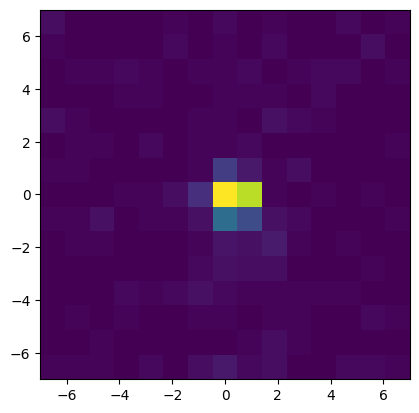

In [34]:
if fit_coefs_at == 'peak':
    vals = coef_locs.reshape(-1, coef_locs.shape[-1])
    vals = vals[np.isfinite(vals).all(1)]
    plt.hist2d(*vals.T, bins=len(rf_locs))
    plt.gca().set_aspect('equal')

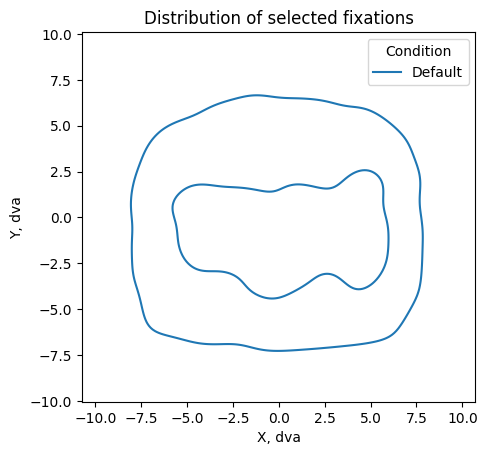

In [35]:
df = {'Condition': [], 'X': [], 'Y': []}
for i, xys in enumerate(xy_degs_conds):
    if select_saccades:
        cond = ('Fixation 1', 'Fixation 2', 'Equidistant control', 'Midpoint control')[i]
    else:
        cond = 'Default'
    df['Condition'].append(np.full(len(xys), cond))
    df['X'].append(xys[:,0])
    df['Y'].append(xys[:,1])
for k in df.keys():
    df[k] = np.concatenate(df[k])
df = pd.DataFrame(df)
ax = sns.kdeplot(data=df, x='X', y='Y', hue='Condition', levels=3)
ax.set_title('Distribution of selected fixations')
ax.set_xlabel('X, dva')
ax.set_ylabel('Y, dva')
ax.set_aspect('equal')

In [36]:
if select_saccades:
    sacc_vecs = (
        fix_df.iloc[fix2_sel][['Relative X', 'Relative Y']].values
        - fix_df.iloc[fix1_sel][['Relative X', 'Relative Y']].values)
    plt.hist2d(x=sacc_vecs[:,0], y=sacc_vecs[:,1], cmap='gist_gray_r')
    plt.xlabel('X, dva')
    plt.ylabel('Y, dva')
    plt.title('Distribution of selected saccade vectors')
    plt.gca().set_aspect('equal')

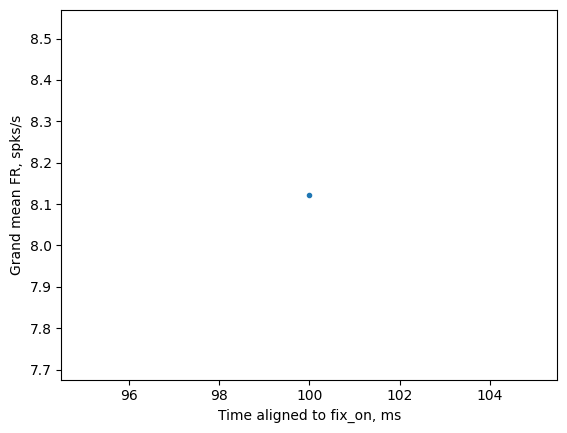

In [37]:
plt.plot(ts, resps.mean((0,2)), '.-')
plt.xlabel(f'Time aligned to {t_aln}, ms')
plt.ylabel('Grand mean FR, spks/s');

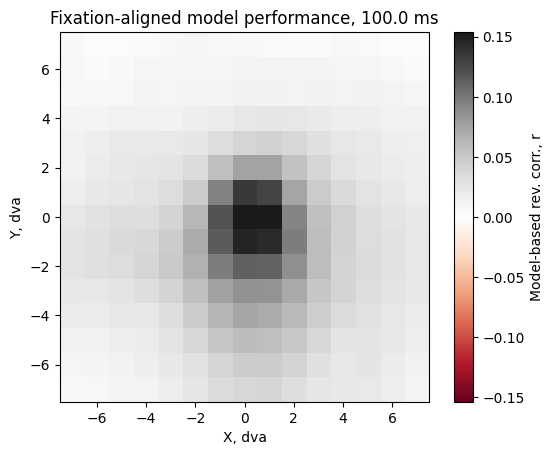

In [38]:
vr = abs(np.nanpercentile(np.nanmean(cv_corrs,-1), 99.5))

i = np.argmin(np.abs(ts - 200))
map_ = np.ma.masked_invalid(cv_corrs[0,i,:,:,:]).mean(-1).filled(np.nan)
cm = plt.imshow(map_, cmap='RdGy', origin='lower', extent=rf_extent, vmin=-vr, vmax=vr)
cb = plt.colorbar(cm)
cb.ax.set_ylabel('Model-based rev. corr., r')
plt.xlabel('X, dva')
plt.ylabel('Y, dva')
if select_saccades:
    plt.title(f'Fix 1-aligned model performance, {ts[i]} ms')
else:
    plt.title(f'Fixation-aligned model performance, {ts[i]} ms')

In [39]:
if select_saccades:
    i = np.argmin(np.abs(ts - 200))
    map_ = np.ma.masked_invalid(cv_corrs[1,i,:,:,:]).mean(-1).filled(np.nan)
    cm = plt.imshow(map_, cmap='RdGy', origin='lower', extent=rf_extent, vmin=-vr, vmax=vr)
    cb = plt.colorbar(cm)
    cb.ax.set_ylabel('Model-based rev. corr., r')
    plt.xlabel('X, dva')
    plt.ylabel('Y, dva')
    plt.title(f'Fix 2-aligned model performance, {ts[i]} ms');

In [40]:
if select_saccades:
    i = np.argmin(np.abs(ts))
    map_ = np.ma.masked_invalid(cv_corrs[1,i,:,:,:]).mean(-1).filled(np.nan)
    cm = plt.imshow(map_, cmap='RdGy', origin='lower', extent=rf_extent, vmin=-vr, vmax=vr)
    cb = plt.colorbar(cm)
    cb.ax.set_ylabel('Model-based rev. corr., r')
    plt.xlabel('X, dva')
    plt.ylabel('Y, dva')
    plt.title(f'Fix 2-aligned model performance, {ts[i]} ms');

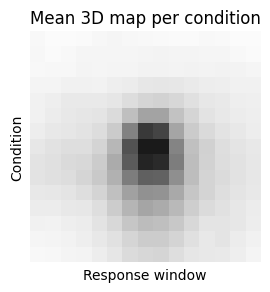

In [41]:
h = 3 * cv_corrs.shape[0]
w = min(h / cv_corrs.shape[0] * cv_corrs.shape[1], 20)
h = min(h, w / cv_corrs.shape[1] * cv_corrs.shape[0])
plt.figure(figsize=(w,h))
a = np.ma.masked_invalid(cv_corrs).mean(-1)
a = a.filled(np.nan)
a = a[:,:,::-1,:]  # flip y such that the first rows now correspond to larger y
a = np.hstack(np.hstack(a))
plt.imshow(a, cmap='RdGy', vmin=-vr, vmax=vr);
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
[v.set_visible(False) for v in ax.spines.values()]
plt.xlabel('Response window')
plt.ylabel('Condition')
plt.title('Mean 3D map per condition');